In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from skimage.feature import hog
from skimage import exposure
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.optimizers import RMSprop

# Load Data

In [2]:
# Import data into a dataframe
train= pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test= pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
print(f"Train Data Info: {train.info()}\n")
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
Train Data Info: None



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(f"Test Data Info: {test.info()}\n")
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
Test Data Info: None



,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Train dataset contains the target and features columns, it has a shape of 785 columns and 42000 rows/observations,while the test dataset contains just the features columns, and is a shape of 784 columns and 28000 rows/observations.

# Split Training Dataset to Targets and Features

In [5]:
target= train["label"]
features= train.drop("label", axis=1)

In [6]:
print(f"Target type: {type(target)}\n")
print(f"Features type: {type(features)}")

Target type: <class 'pandas.core.series.Series'>

Features type: <class 'pandas.core.frame.DataFrame'>


In [7]:
print(target.head())
features.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


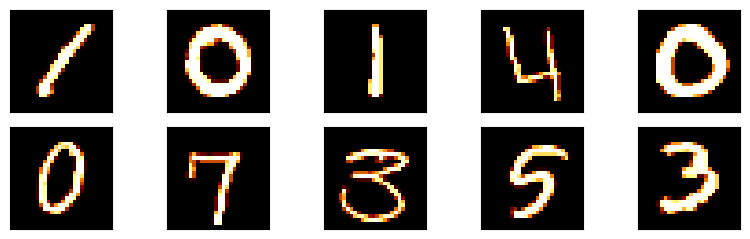

In [8]:
# plot some of the numbers
plt.figure(figsize=(8,6))
for digit_num in range(0,10):
    plt.subplot(5,5,digit_num+1)
    grid_data = features.iloc[digit_num].to_numpy().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [9]:
# Basic analysis
bstats= {"mean": np.mean(features, axis=1), "variance": np.var(features, axis=1), "std":np.std(features, axis=1) }
stats=pd.DataFrame(bstats)
stats

,mean,variance,std
0,21.235969,4175.613961,64.618991
1,56.899235,9830.412040,99.148434
2,17.123724,3554.649233,59.620879
3,19.164541,3335.083896,57.750185
4,65.169643,10982.077089,104.795406
...,...,...,...
41995,37.385204,6493.440904,80.581889
41996,17.110969,3638.376716,60.318958
41997,40.183673,7614.802999,87.262839
41998,33.649235,6232.265994,78.944702


array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'variance'}>],
       [<Axes: title={'center': 'std'}>, <Axes: >]], dtype=object)

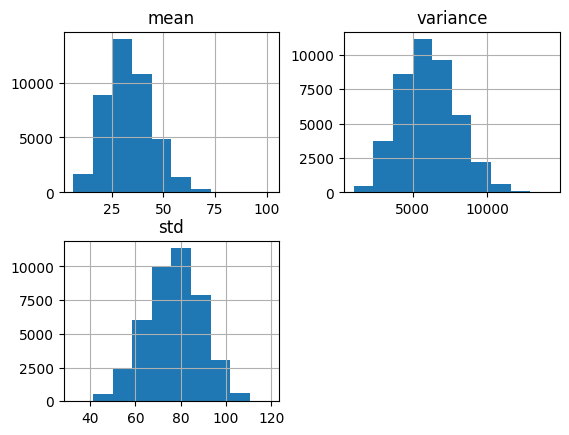

In [10]:
stats.hist()

# Preprocessing the Datasets
- Data Noramlization
- Scaling Data

This will normalize features to be between 0 and 1 and then standardize them so that they have a mean of 0 and a standard deviation of 1

In [11]:
def preprocess_data(data):
    # Normalize the data
    feat_norm = data / 255.0

    # Initialize a new StandardScaler instance
    scaler = StandardScaler()

    # Fit the scaler to the data
    scaler.fit(feat_norm)

    # Transform the data
    feat_scaled = scaler.transform(feat_norm)
    
    # Reshape the data to 28x28 images
    feat_reshape = feat_scaled.reshape(-1, 28, 28)
    
    return feat_reshape


In [12]:
feat_train= preprocess_data(features)
feat_test= preprocess_data(test)

In [13]:
# Datatype
print(f"Train Scaled DataType: {type(feat_train)}")
print(f"Test Scaled DataType: {type(feat_test)}")

Train Scaled DataType: <class 'numpy.ndarray'>
Test Scaled DataType: <class 'numpy.ndarray'>


In [14]:
# Printing the Data
print(f"Train Scaled Data: \n {feat_train[0:5]}\n")
print(f"Test Scaled Data: \n {feat_test[0:5]}")

Train Scaled Data: 
 [[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.         -0.00487956 ... -0.00805699  0.
    0.        ]
  ...
  [ 0.          0.         -0.00796544 ... -0.00678334 -0.00487956
    0.        ]
  [ 0.          0.          0.         ... -0.00487956  0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.         -0.00487956 ... -0.00805699  0.
    0.        ]
  ...
  [ 0.          0.         -0.00796544 ... -0.00678334 -0.00487956
    0.        ]
  [ 0.          0.          0.         ... -0.00487956  0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0. 

In [15]:
print(f"Train Scaled Data Shape: \n {feat_train.shape}\n")
print(f"Test Scaled Data Shape: \n {feat_test.shape}")

Train Scaled Data Shape: 
 (42000, 28, 28)

Test Scaled Data Shape: 
 (28000, 28, 28)


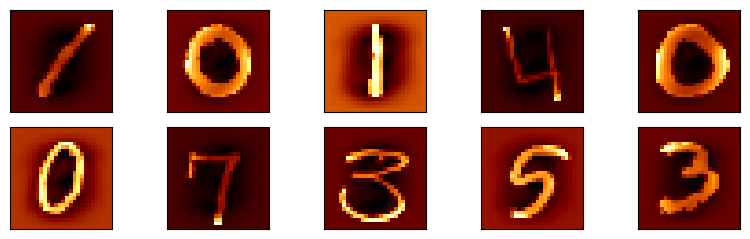

In [16]:
# plot some of the numbers preprocessed image
plt.figure(figsize=(8,6))
for digit_num in range(0,10):
    plt.subplot(5,5,digit_num+1)
    grid_data = feat_train[digit_num]
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

# Feature Extraction
Using Histogram of Oriented Gradients (HOG) we are going to extract important features based on their orientation. HOG is used in capturing the shape or structure of objects within an image. HOG is a feature descriptor that involves counting occurrences of gradient orientation in localized portions of an image.

In [17]:
# Calculate HOG features of the Features
hog_features = [hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1)) for image in feat_train]


print(f"Data Type: {type(hog_features)}\n")
print(f"Lenght of Data: {len(hog_features)}")

Data Type: <class 'list'>

Lenght of Data: 42000


In [18]:
hog_feat_array= np.array(hog_features)

print("HOG features:")
print(hog_feat_array, "\n")
print(f"Data Type: {type(hog_feat_array)}\n")
print(f"Lenght of array: {len(hog_feat_array)}")

HOG features:
[[0.08180151 0.70074096 0.70074096 ... 0.         0.05455105 0.12670638]
 [0.57436319 0.57436319 0.57436319 ... 0.1069198  0.03525005 0.23223445]
 [0.08180151 0.70074096 0.70074096 ... 0.1042601  0.         0.49727503]
 ...
 [0.03663915 0.5763236  0.5763236  ... 0.04222903 0.0111845  0.31129842]
 [0.08180151 0.70074096 0.70074096 ... 0.         0.23377674 0.34067101]
 [0.08180151 0.70074096 0.70074096 ... 0.         0.13625374 0.55039942]] 

Data Type: <class 'numpy.ndarray'>

Lenght of array: 42000


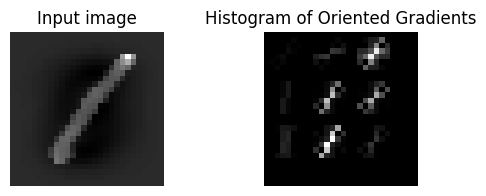

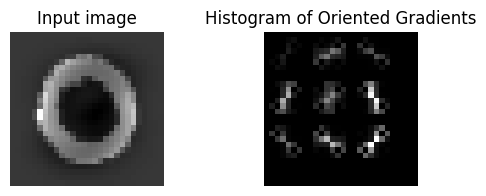

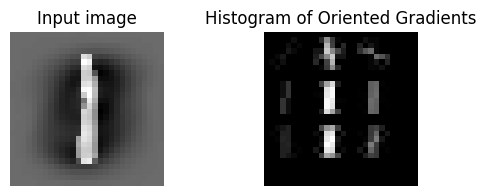

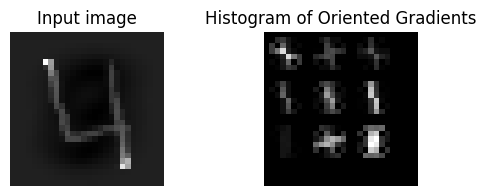

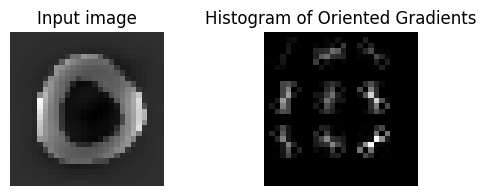

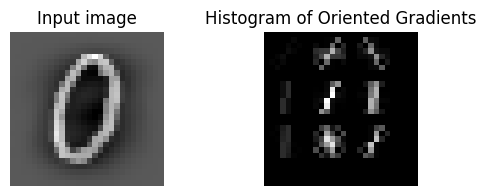

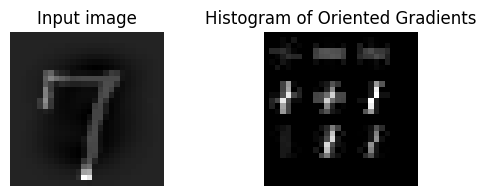

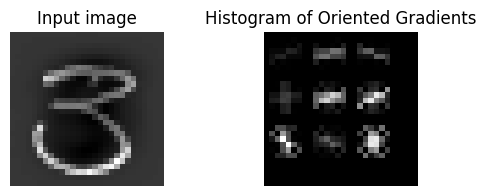

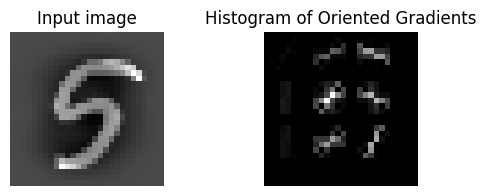

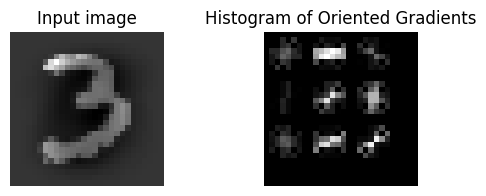

In [19]:
# Selecting a subset of images to work with (for example, first 10 images)
subset_images = feat_train[:10]

# Calculate HOG features and visualize for each image in the subset
for i, image in enumerate(subset_images):
    hog_features, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True)

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Plot the original image and the HOG features
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(image, cmap=plt.cm.gray)
    ax1.set_title('Input image')

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')

    plt.show()


The HOG feature extraction algorithm is applied to extract and vectorize the images, these vectors (arrays) are very large and will take up lots of memory. To reduce these vectors PCA will be used.

Principal Component Analysis (PCA) is a linear transformation algorithm that seeks to project the original features of our data onto a smaller set of features ( or subspace ) while still retaining most of the information.

In [20]:
# Initialize PCA
pca = PCA(n_components=0.95)

# Fit and transform the data to the model
reduced_feat = pca.fit_transform(hog_feat_array)

print("Reduced dataset shape:", reduced_feat.shape)
print("Reduced Data type:", type(reduced_feat))

Reduced dataset shape: (42000, 50)
Reduced Data type: <class 'numpy.ndarray'>
